In [79]:
# needed imports
from matplotlib import pyplot as plt
import scipy.cluster.hierarchy as sch
import numpy as np
import pandas as pd
 
#Import Data, droping Summe and ID
X = pd.read_excel("./Data with time stemps reduced.xlsx", "Matrix without time").drop(columns=['Summe', 'ID'])
X_random = pd.read_excel("./Data with time stemps reduced.xlsx", "Matrix randomisiert").drop(columns=['ID']) 
software = list(X.columns)
X_random_transpose = X_random.transpose()
X

,S0066,S0065,S0469,S0045,S0073,S0552,S0331,S0092,S0504,S0584,...,S0385,S0067,S0006,S0103,S0111,S0227,S0225,S0123,S0248,S0350
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
265,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
266,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
267,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


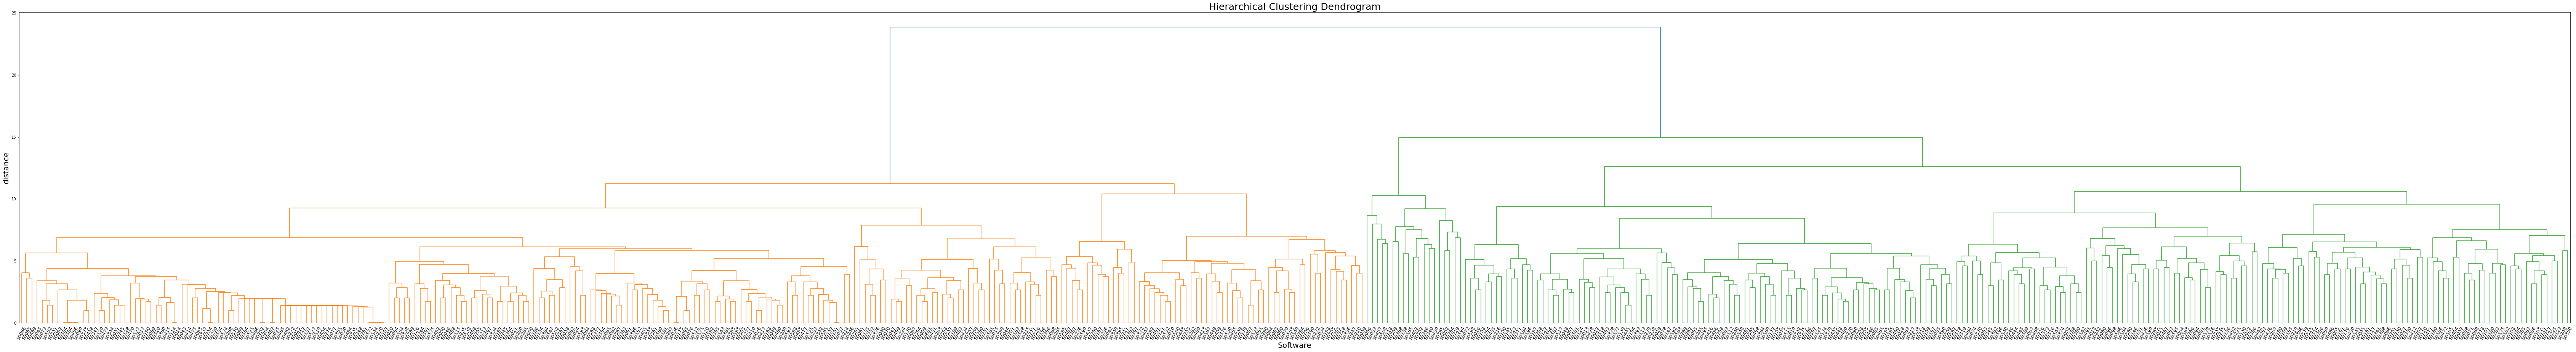

In [56]:
linked = sch.linkage(X_random_transpose, method = 'ward', metric= 'euclidean')
#labels = ["A", "B", "C", "D"]
labels = software

p = len(labels)

plt.figure(figsize=(120, 15))
plt.title('Hierarchical Clustering Dendrogram', fontsize=25)
plt.xlabel('Software', fontsize=20)
plt.ylabel('distance', fontsize=20)

# call dendrogram to get the returned dictionary 
# (plotting parameters can be ignored at this point)
R = sch.dendrogram(
                linked,
                truncate_mode='lastp',  # show only the last p merged clusters
                p=p,  # show only the last p merged clusters
                no_plot=True,
                )

# create a label dictionary
temp = {R["leaves"][ii]: labels[ii] for ii in range(len(R["leaves"]))}
def llf(xx):
    return "{}".format(temp[xx])

## This version gives you your label AND the count
# temp = {R["leaves"][ii]:(labels[ii], R["ivl"][ii]) for ii in range(len(R["leaves"]))}
# def llf(xx):
#     return "{} - {}".format(*temp[xx])


sch.dendrogram(
            linked,
            truncate_mode='lastp',  # show only the last p merged clusters
            p=p,  # show only the last p merged clusters
            leaf_label_func=llf,
            leaf_rotation=60.,
            leaf_font_size=12.,
            show_contracted=True,  # to get a distribution impression in truncated branches
            )

plt.show()

In [58]:
#cutree = sch.cut_tree(linked, height = )
cluster_id, cluster_level = cut_tree_balanced(linked, 20)

493

In [78]:
#Cluster mit ID und zugehörigen Software als csv speichern
id_list = cluster_id.tolist()
id_list

cluster_df = pd.DataFrame(list(zip(software, cluster_id.tolist())), columns = ['Software_ID', 'Cluster_ID']).set_index('Software_ID')
cluster_df = cluster_df.sort_values(by = 'Cluster_ID')
cluster_df.transpose()
cluster_df.to_csv('cluster.csv', sep = ";")

In [ ]:
#mögliche Ausprogamierung der Methode word

def ward_link(clusters, i, j, dendrogram):
    """
    Hierarchical Agglomerative Clustering using Ward's linkage. Two clusters i
    and j are merged when their merge results in the smallest increase in the
    sum of error squares in the vector space.
    
    Lance-Williams parameters:
    
    M{S{alpha}(i) = (|i| + |k|) / (|i| + |j| + |k|); 
    S{beta} = -|k|/(|i| + |j| + |k|); S{gamma} = 0}
    """
    n_i, n_j = len(dendrogram[i]), len(dendrogram[j])
    def ward_update(d_ik, d_jk, k):
        n_k = len(dendrogram[k])
        n_ijk = n_i+n_j+n_k
        return ( (n_i+n_k)/(n_ijk)*d_ik + (n_j+n_k)/(n_ijk)*d_jk +
                 -(n_k/(n_ijk))*clusters[i][j] )
    return _general_link(clusters, i, j, ward_update)

In [12]:
# Quelle: https://github.com/vreyespue/scipy_cut_tree_balanced/blob/master/scipy_cut_tree_balanced/util.py
# Methode um den Tree balanciert zu cutten
def cut_tree_balanced(Z, max_cluster_size):
    """
    Parameters
    ----------
    Z : ndarray
        The linkage matrix resulting from calling `ward` or `linkage`. I.e. it
        contains the hierarchical clustering encoded as a linkage matrix.
    max_cluster_size : int
        Maximum number of data samples contained within the resulting clusters.
        Thus, all resulting clusters will contain a number of data samples
        ``<= max_cluster_size``. Must be >= 1.
    Returns
    -------
    cluster_id : ndarray
        One-dimensional array of integers containing for each input sample its
        corresponding cluster id. The cluster id is an integer which is higher
        for deeper tree levels.
    cluster_level : ndarray
        One-dimensional array of integer arrays containing for each input
        sample its corresponding cluster tree level, i.e. a sequence of
        0's and 1's. Note that the cluster level is longer for deeper tree
        levels, being [0] the root cluster, [0, 0] and [0, 1] its offspring,
        and so on. Also note that in each cluster splitting, the label 0
        denotes the bigger cluster, while the label 1 denotes the smallest.
    See Also
    --------
    cut_tree
    Notes
    -----
"""
    # Assert that the input max_cluster_size is >= 1
    if not max_cluster_size >= 1:
        raise ValueError(
            "max_cluster_size should be >= 1, is: {}".format(max_cluster_size)
        )

    # Perform a full cut tree of the linkage matrix
    full_cut = cut_tree(Z)

    # Initialize the variable containing the current cluster id (it will be
    # higher for each newly found valid cluster)
    last_cluster_id = 0

    # Initialize the resulting cluster id vector (containing for each row in
    # input_data_x_sample its corresponding cluster id)
    ndim = full_cut.shape[1]
    cluster_id = np.zeros(ndim, dtype=int)

    # Initialize the resulting cluster level vector (containing for each data
    # sample its corresponding cluster tree level)
    cluster_level = np.empty((ndim,), dtype=object)
    for i in range(ndim):
        cluster_level[i] = np.array([0], int)

    # Scan the full cut matrix from the last column (root tree level) to the
    # first column (leaves tree level)
    for icol in range(ndim - 1, -1, -1):
        # Get a list of unique group ids and their count within the current
        # tree level
        values, counts = np.unique(full_cut[:, icol], return_counts=True)

        # Stop if all samples have been already selected (i.e. if all data
        # samples have been already clustered)
        if (values.size == 1) and (values[0] == -1):
            break

        # For each group id within the current tree level
        for ival in range(values.size):
            # If it is a valid group id (i.e. not yet marked with -1)
            # Note: data samples which were alredy included in a valid
            # cluster id are marked with the group id -1 (see below)
            if values[ival] >= 0:
                # Select the current group id
                selected_curr_value = values[ival]

                # Look for the vector positions (related to rows in
                # input_data_x_sample) belonging to the current group id
                selected_curr_elems = np.where(full_cut[:, icol] == selected_curr_value)

                # Major step #1: Populate the resulting vector of cluster
                # levels for each data sample, if we are not at the root
                if icol < (ndim - 1):
                    # Get the ancestor values and element positions
                    selected_ancestor_value = full_cut[
                        selected_curr_elems[0][0], icol + 1
                    ]
                    selected_ancestor_elems = np.where(
                        full_cut[:, icol + 1] == selected_ancestor_value
                    )

                    # Compute the values and counts of the offspring and sort
                    # them by their count (so that the biggest cluster gets the
                    # offspring_elem_label = 0, see below)
                    offspring_values, offspring_counts = np.unique(
                        full_cut[selected_ancestor_elems, icol], return_counts=True
                    )
                    count_sort_ind = np.argsort(-offspring_counts)
                    offspring_values = offspring_values[count_sort_ind]
                    offspring_counts = offspring_counts[count_sort_ind]

                    # If the size of the offspring is > 1
                    if offspring_values.shape[0] > 1:
                        # Select the label of the current value (i.e. 0 or 1)
                        # and append it to the cluster level
                        offspring_elem_label = np.where(
                            offspring_values == selected_curr_value
                        )[0][0]
                        for i in selected_curr_elems[0]:
                            cluster_level[i] = np.hstack(
                                (cluster_level[i], offspring_elem_label)
                            )

                # Major step #2: Populate the resulting vector of cluster ids
                # for each data sample, and mark them as clustered (-1)
                # If the number of elements is below max_cluster_size
                if counts[ival] <= max_cluster_size:
                    # Relate vector positions to the current cluster id
                    cluster_id[selected_curr_elems] = last_cluster_id

                    # Delete these vector positions at lower tree levels for
                    # further processing (i.e. mark as clustered)
                    full_cut[selected_curr_elems, 0:icol] = -1

                    # Update the cluster id
                    last_cluster_id += 1

    # Return the resulting clustering array (containing for each row in
    # input_data_x_sample its corresponding cluster id)
    return cluster_id, cluster_level